<h2>Goals and task steps</h2>
Story and Bunton 2017 used the following steps in MatLab to get a data set representing the vowel space density:

1. Determine all voiced intervals in the recording
2. Downsample the audio to 10 kHz
3. Consider overlapping 40 ms windows, tapered with a gaussian at each edge, giving formant values determined at 5ms steps
4. For each voiced interval, process F1 & F2 values with "a three-point median filter followed by a five-point smoothing filter". *What does this mean, and how does it benefit them?*
5. Final product: join voiced intervals, for values of F1 and F2 corresponding to N steps through an audio recording. *It will be discontinuous. Is that a problem?*
6. Normalize relative to the "median" F1 and F2 values. *They reference Disner 1980 Evaluation of vowel normalization procedures.*
7. Calculating "density": first generate a grid with an increment of 0.01, thus representing 1% of the median formant frequencies. This was found to provide sufficient resolution for visualization and analysis of VSD. Position a circular field of view, or “lens,” of a specified radius (0.05 was what they used) at every point in the grid and count the number of [F∗1,F∗2] pairs contained within the view of the lens.
8. Normalizing density, too: "the density values at every grid point were divided by the maximum density value found within the entire grid."
9. Calculating VSD: "For this study, a value of 0.25 was selected as the density level at which an enclosed area was measured so that low density values representing infrequent or spurious formant pairs at the extremes of the vowel space would not contribute to the VSD area." ... "A convex hull algorithm (cf. Graham, 1972; Andrew, 1979) was then used to geometrically wrap a “band” around the perimeter of the set to generate the enclosed area. The built-in matlab function called “convhull” was implemented for this purpose in the current study. It accepts as input the set of x-y grid pairs from which it finds the convex hull and enclosed area."

I won't be working in MatLab; I don't have a license. Moreover, I'd like to create a procedure that can be used by anyone else to generate a similar data set, either duplicating and verifying my own work or applying this tool to their own language data. I'm therefore going to do everything with open source software and keep the documentation on GitHub. So, I'll be using Praat and Python&mdash;both freely available. I can program, but I know that others are better at optimization than I am, so I'll try to leverage existing libraries as much as possible.

Here's a schematic procedure which, I think, gets a comparable set of data:

1. Use Praat to calculate the formant traces.

*Since formant traces in anything besides voiced segments will be spurious, by the end of this process these traces need to be limited to just voiced intervals. Praat **could** find all the voiced segments and then calculate the formants across the whole concatenated mess, but this would lead to inaccurate formant calculations whenever the formant calculation window spanned one of the gaps where a voiceless interval was removed. Smoothing the data after any voiceless intervals have been removed would also introduce problems by smoothing across the discontinuous gaps. So, I'll calculate formants across the whole audio sample, perform any smoothing&mdash;SciPy offers some smoothing tools&mdash;and lastly remove the formant data from any voiceless intervals. If I'm calculating formants in Praat but doing the smoothing in Python, I'll need to have Praat output both the formant data and the voiced interval times, so that just the voiced intervals can be chosen after the smoothing has been performed.*

*Here's an interesting idea: Run Praat in Python using Parselmouth, or a modification of it, so that all of the operations can be done without having to go into Praat manually: https://osf.io/6dwr3/*

2. After getting the formants, perform some checks to make sure the data seems reasonable.

*Make sure that the maximum and minimum values for F1 and F2 (and maybe other formants later) fall into reasonable ranges. The conclusions will not stand if the data is not clean.*

3. Use Python-based tools to normalize the data and calculate the vowel space density (SciPy.stats includes a function KDE, the kernel density estimation) and convex hull area (SciPy.spatial includes a function ConvexHull). Python-based tools (MatPlotLib) can also display the VSD.

*Another goal, if this turns out to be a useful tool, will be to find a way to compare one VSD cloud to another, or compare more than just the convex hull area&mdash;maybe the share of the convex hull, in two dimensions (F1 and F2) or even three (F1, F2, and F3)*

In [1]:
import parselmouth
import tgt
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set() # Use seaborn's default style to make attractive graphs

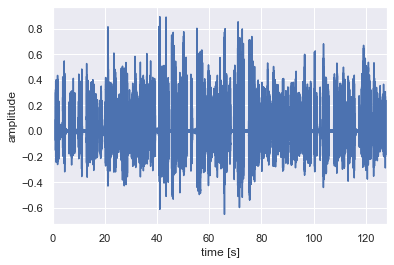

In [3]:
# This example from Parselmouth on GitHub: https://github.com/YannickJadoul/Parselmouth

# Plot nice figures using Python's "standard" matplotlib library
snd = parselmouth.Sound("./test1.wav")
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

Let's start by listing here some of the constants that I want to use for the calculations.

In [4]:
# CONSTANTS

# Formant analysis parameters
#   FOR A WOMAN:
# To Formant (burg)... 0.005 5.0 5500.0 0.025 50.0
#   FOR A MAN:
# To Formant (burg)... 0.005 5.0 5000.0 0.025 50.0

time_step = 0.005
max_formant_num = 5
max_formant_freq = 5500
window_length = 0.025
preemphasis = 50

# Pitch analysis parameters
pitch_time_step = 0.005
pitch_floor = 60
max_candidates = 15
very_accurate = False
silence_thresh = 0.03
voicing_thresh = 0.7
octave_cost = 0.01
oct_jump_cost = 0.35
vuv_cost = 0.14
pitch_ceiling = 600.0
max_period = 0.02

# Other constants
tier = 1
outfile = "voiced_intervals.csv"
path = "test1.wav"

sound = parselmouth.Sound(path)

Next, get all formants across the whole file. Some will be "wrong," because Praat's calculation won't actually find proper formants in certain kinds of phones. This should be okay, because we'll end up cutting out all of the data that is "wrong" by the end. (...or at least it's our intent that we will.)

In [5]:
formants = sound.to_formant_burg(time_step,
                                 max_formant_num,
                                 max_formant_freq,
                                 window_length,
                                 preemphasis)

data_table = parselmouth.praat.call(formants, "Down to Table...", False, True, 6, False, 3, True, 3, False)
# parselmouth.praat.call(Save as tab-separated file: name$ + "_formants.csv"
print(data_table)

Object type: Table
Object name: untitled
Date: Mon Mar 29 21:45:29 2021

Number of rows: 25655
Number of columns: 7



In [6]:
# The Formant object for the whole sound can be put into a DataFrame using StringIO.
#  Thanks to Yannick Jadoul for this suggestion
import io
temp = pd.read_csv(io.StringIO(parselmouth.praat.call(data_table, "List", True)), sep='\t')
temp

,row,time(s),nformants,F1(Hz),F2(Hz),F3(Hz),F4(Hz),F5(Hz)
0,1,0.025615,4,424.947,2065.922,3355.977,4532.285,--undefined--
1,2,0.030615,4,1111.613,2570.318,3564.852,4146.409,--undefined--
2,3,0.035615,4,798.367,2032.961,3202.946,4218.430,--undefined--
3,4,0.040615,4,558.915,1865.224,3179.625,4278.080,--undefined--
4,5,0.045615,4,151.915,1814.673,3186.265,4198.066,--undefined--
...,...,...,...,...,...,...,...,...
25650,25651,128.275615,3,1859.839,3272.122,4399.447,--undefined--,--undefined--
25651,25652,128.280615,3,1886.530,3258.996,4302.018,--undefined--,--undefined--
25652,25653,128.285615,3,1861.747,3208.915,4168.759,--undefined--,--undefined--
25653,25654,128.290615,4,1627.194,2960.999,4124.295,4926.419,--undefined--


<h2>Smoothing</h2>

In <a href="https://dx.doi.org/10.1121%2F1.4983342">Story & Bunton 2017</a>, who proposed using vowel space density as part of a set of diagnostics for characterization of speech, they used two filters to preprocess the formant traces: a "3-point median filter" followed by a "5-point smoothing filter". Brad's reasoning was that the first filter removes spurious outliers, then the second filter smooths the trace.

I'm not exactly sure of the specifics of their implementation of a median filter, but I did discover that SciPy has a built-in smoothing function:

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

mentions a procedure called a Savitzky-Golay filter, which has been implemented in SciPy.

In [7]:
from scipy.signal import savgol_filter

# yhat = savgol_filter(y, 5, 3) # window size 5, polynomial order 3

temp["F1(Hz)"] = savgol_filter(temp["F1(Hz)"], 5, 3)
temp["F2(Hz)"] = savgol_filter(temp["F2(Hz)"], 5, 3)
temp["F3(Hz)"] = savgol_filter(temp["F3(Hz)"], 5, 3)

<h2>Voiced intervals</h2>
Now, to get the voiced intervals. *TextGridTools* `TGT` will allow getting the data out of the text grid more easily.

In [8]:
pitch = sound.to_pitch_ac(pitch_time_step,
                          pitch_floor,
                          max_candidates,
                          very_accurate,
                          silence_thresh,
                          voicing_thresh,
                          octave_cost,
                          oct_jump_cost,
                          vuv_cost,
                          pitch_ceiling)

mean_period = 1/parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.5, "Hertz")
pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")
tgrid = parselmouth.praat.call(pulses, "To TextGrid (vuv)", 0.02, mean_period)

print(tgrid)

Object type: TextGrid
Object name: untitled_untitled
Date: Mon Mar 29 21:45:39 2021

Number of interval tiers: 1
Number of point tiers: 0
Number of intervals: 445
Number of points: 0



In [9]:
VUV = pd.DataFrame(pd.read_csv(io.StringIO(tgt.io.export_to_table(tgrid.to_tgt(), separator=','))))
VUV

,tier_name,tier_type,start_time,end_time,text
0,vuv,IntervalTier,0.000000,1.100886,U
1,vuv,IntervalTier,1.100886,1.243106,V
2,vuv,IntervalTier,1.243106,1.334607,U
3,vuv,IntervalTier,1.334607,1.648636,V
4,vuv,IntervalTier,1.648636,1.692848,U
...,...,...,...,...,...
440,vuv,IntervalTier,127.369883,127.475181,U
441,vuv,IntervalTier,127.475181,127.676223,V
442,vuv,IntervalTier,127.676223,127.693065,U
443,vuv,IntervalTier,127.693065,128.090758,V


In [10]:
# Getting just the voiced intervals
VUV['start_time'][VUV["text"] == "V"]

1        1.100886
3        1.334607
5        1.692848
7        2.328277
9        3.680803
          ...    
435    126.318779
437    126.514979
439    127.040363
441    127.475181
443    127.693065
Name: start_time, Length: 222, dtype: float64

In [11]:
voiced_interval_array = pd.IntervalIndex.from_arrays(VUV['start_time'][VUV["text"] == "V"],
                                                     VUV['end_time'][VUV["text"] == "V"],
                                                     closed='left')
formants_voiced = temp[voiced_interval_array.get_indexer(temp["time(s)"].values) != -1]
formants_voiced

,row,time(s),nformants,F1(Hz),F2(Hz),F3(Hz),F4(Hz),F5(Hz)
216,217,1.105615,5,479.781343,2240.379229,3086.418114,4100.960,5008.901
217,218,1.110615,5,477.942457,2268.804743,3082.539029,4036.156,4676.939
218,219,1.115615,5,476.894314,2323.489971,3084.562086,4068.208,4558.995
219,220,1.120615,5,473.414629,2367.786314,3083.611114,4095.488,4429.937
220,221,1.125615,5,465.185143,2384.955229,3082.028657,4095.774,4388.667
...,...,...,...,...,...,...,...,...
25609,25610,128.070615,4,543.695400,1551.150971,2840.222686,3870.317,--undefined--
25610,25611,128.075615,4,618.956171,1538.314857,2850.714771,3815.094,--undefined--
25611,25612,128.080615,4,663.001371,1510.296371,2891.747029,3860.592,--undefined--
25612,25613,128.085615,4,637.949371,1479.600286,2906.634486,3964.193,--undefined--


In [14]:
filter = formants_voiced["nformants"] > 3

In [15]:
formants_voiced[filter]

,row,time(s),nformants,F1(Hz),F2(Hz),F3(Hz),F4(Hz),F5(Hz)
216,217,1.105615,5,479.781343,2240.379229,3086.418114,4100.960,5008.901
217,218,1.110615,5,477.942457,2268.804743,3082.539029,4036.156,4676.939
218,219,1.115615,5,476.894314,2323.489971,3084.562086,4068.208,4558.995
219,220,1.120615,5,473.414629,2367.786314,3083.611114,4095.488,4429.937
220,221,1.125615,5,465.185143,2384.955229,3082.028657,4095.774,4388.667
...,...,...,...,...,...,...,...,...
25609,25610,128.070615,4,543.695400,1551.150971,2840.222686,3870.317,--undefined--
25610,25611,128.075615,4,618.956171,1538.314857,2850.714771,3815.094,--undefined--
25611,25612,128.080615,4,663.001371,1510.296371,2891.747029,3860.592,--undefined--
25612,25613,128.085615,4,637.949371,1479.600286,2906.634486,3964.193,--undefined--


In [16]:
formants_voiced["F1(Hz)"].describe()

count    14174.000000
mean       504.962483
std        163.346539
min        103.814314
25%        402.635514
50%        446.416943
75%        554.767421
max       1711.096429
Name: F1(Hz), dtype: float64

Hmm, this range (60 Hz to 1600 Hz) seems like it might be high, even for a woman. How about showing how the data is spread around these values?

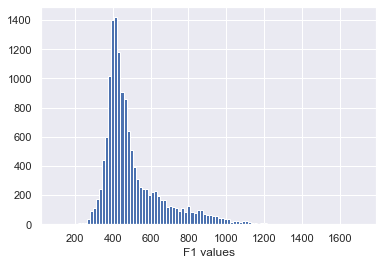

In [17]:
nbins = 100
n, bins, patches = plt.hist(formants_voiced["F1(Hz)"], nbins, log=False)

plt.rcParams['figure.figsize'] = [12, 8]

plt.xlabel('F1 values')
plt.grid(True)
plt.show()

In [18]:
formants_voiced["F2(Hz)"].describe()

count    14174.000000
mean      1799.776865
std        484.324623
min        145.775514
25%       1449.026807
50%       1766.865400
75%       2136.732186
max       3276.496429
Name: F2(Hz), dtype: float64

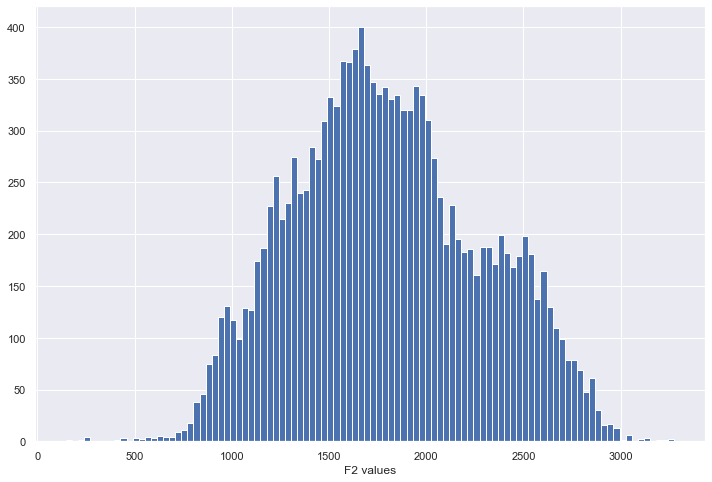

In [19]:
nbins = 100
n, bins, patches = plt.hist(formants_voiced["F2(Hz)"], nbins, log=False)

plt.xlabel('F2 values')
plt.grid(True)
plt.show()